In [1]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, LSTM, Flatten, Reshape
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.keras import backend as K
import gc
import tensorflow as tf
import random
from sklearn import preprocessing
import pickle
from utilities import *

In [2]:
#Load config
config = loadData("config")
dataSetSize = config["dataSetSize"]
testSetBenignSize = config["testSetBenignSize"]
validationSetSize = config["validationSetSize"]
trainingSetSize = config["trainingSetSize"]
sequenceLen = config["sequenceLen"]
dimensionsCount = config["dimensionsCount"]
attackSamplesCount = config["attackSamplesCount"]
testSetSize = testSetBenignSize + attackSamplesCount

### Prepare attack data

In [3]:
normalizedDataSet = loadData("normalized_data_set")
normalizedAngleShiftAttackDataSet = loadData("normalized_angle_shift_attack_data_set")
normalizedFDIAttackDataSet = loadData("normalized_fdi_attack_data_set")
normalizedTimeSyncAttackDataSet = loadData("normalized_time_sync_attack_data_set")

# for now we mix all three attack data sets into one
attackDataSet = np.concatenate((normalizedAngleShiftAttackDataSet, normalizedFDIAttackDataSet, normalizedTimeSyncAttackDataSet), axis=0)
sampledAttackDataSet = np.array(random.sample(list(attackDataSet), attackSamplesCount))
#sampledAttackDataSet = attackDataSet
testSetBenign = np.reshape(normalizedDataSet[trainingSetSize:trainingSetSize+testSetBenignSize,:,:,:], (testSetBenignSize,sequenceLen,dimensionsCount), order = 'C')
testSetAttack = np.reshape(sampledAttackDataSet, (attackSamplesCount,sequenceLen,dimensionsCount), order = 'C')
testSet = np.concatenate((testSetBenign,testSetAttack))
test_labels = np.zeros(testSetSize)
test_labels[testSetBenignSize:] = np.ones(attackSamplesCount)

In [4]:
print("testSetBenignSize",testSetBenignSize)
print("attackSamplesCount",attackSamplesCount)
print("test_labels shape",test_labels.shape)
print("testSetBenign shape",testSetBenign.shape)
print("testSetAttack shape",testSetAttack.shape)

testSetBenignSize 1382
attackSamplesCount 1000
test_labels shape (2382,)
testSetBenign shape (1382, 200, 9)
testSetAttack shape (1000, 200, 9)


In [5]:
def rankedPrecision(mse_labels):
    sorted_mse_label = mse_label[mse_label[:,0].argsort()[::-1]]
    totalNumberOfAnomalies = sum(sorted_mse_label[:,1] == 1)
    TP = sum(sorted_mse_label[0:totalNumberOfAnomalies,1] == 1)
    FP = sum(sorted_mse_label[0:totalNumberOfAnomalies,1] == 0)
    TN = sum(sorted_mse_label[totalNumberOfAnomalies:,1] == 0)
    FN = sum(sorted_mse_label[totalNumberOfAnomalies:,1] == 1)
    precision = TP/(TP+FP)
    return precision
    
    
def rankedRecall(mse_labels):
    sorted_mse_label = mse_label[mse_label[:,0].argsort()[::-1]]
    totalNumberOfAnomalies = sum(sorted_mse_label[:,1] == 1)
    TP = sum(sorted_mse_label[0:totalNumberOfAnomalies,1] == 1)
    FP = sum(sorted_mse_label[0:totalNumberOfAnomalies,1] == 0)
    TN = sum(sorted_mse_label[totalNumberOfAnomalies:,1] == 0)
    FN = sum(sorted_mse_label[totalNumberOfAnomalies:,1] == 1)
    recall = TP/(TP+FN)
    return recall

# show_curve() is for plotting training and validation losses
def show_curve(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
    
def rankedPrecisionThre(mse_labels,threshold):
    sorted_mse_label = mse_label[mse_label[:,0].argsort()[::-1]]
    TP = sum((sorted_mse_label[:,1] == 1) & (sorted_mse_label[:,0] >= threshold))
    FP = sum((sorted_mse_label[:,1] == 0) & (sorted_mse_label[:,0] >= threshold))
    TN = sum((sorted_mse_label[:,1] == 0) & (sorted_mse_label[:,0] < threshold))
    FN = sum((sorted_mse_label[:,1] == 1) & (sorted_mse_label[:,0] < threshold))
    precision = TP/(TP+FP)
    return precision
    
    
def rankedRecallThre(mse_labels,threshold):
    sorted_mse_label = mse_label[mse_label[:,0].argsort()[::-1]]
    TP = sum((sorted_mse_label[:,1] == 1) & (sorted_mse_label[:,0] >= threshold))
    FP = sum((sorted_mse_label[:,1] == 0) & (sorted_mse_label[:,0] >= threshold))
    TN = sum((sorted_mse_label[:,1] == 0) & (sorted_mse_label[:,0] < threshold))
    FN = sum((sorted_mse_label[:,1] == 1) & (sorted_mse_label[:,0] < threshold))
    recall = TP/(TP+FN)
    return recall

In [6]:
# To store thresholds
thresholds = {}

### PCA

In [7]:
testSet = getReshapedTestSet(testSet, 'PCA')
precisions = []
recalls = []
model = load_model('Trained_Model/pca.h5')
predicted = model.predict(testSet)
mse = (np.square(testSet - predicted)).mean(axis=1)
mse_label = np.vstack((mse, test_labels)).T
precision = rankedPrecision(mse_label)
recall = rankedRecall(mse_label)
precisions.append(precision)
recalls.append(recall)
print("Precision is: ", precision)
print("Recall is: ", precision)

LSTMPrecisions_domain = precisions

sorted_mse_label = mse_label[mse_label[:,0].argsort()[::-1]]

totalNumberOfAnomalies = sum(sorted_mse_label[:,1] == 1)
print("Min reconstruction error for anomalies: ", min(sorted_mse_label[sorted_mse_label[:,1] == 1,0])) # 0.010118610983828593
print("max reconstruction error for benign: ", max(sorted_mse_label[sorted_mse_label[:,1] == 0,0])) 


sorted_mse_label = mse_label[mse_label[:,0].argsort()[::-1]]
minMSE = min(sorted_mse_label[sorted_mse_label[:,1] == 0,0])
maxMSE = max(sorted_mse_label[sorted_mse_label[:,1] == 0,0])
thre = maxMSE + (maxMSE - minMSE)/10
thresholds["PCA"] = thre
print("Selected threshold: ",thre)
precision = rankedPrecisionThre(mse_label,thre)
recall = rankedRecallThre(mse_label,thre)
print("Precision by threshold is: ", precision)
print("Recall by threshold is: ", recall)

Precision is:  1.0
Recall is:  1.0
Min reconstruction error for anomalies:  0.025712678854459048
max reconstruction error for benign:  0.0011677688693006027
Selected threshold:  0.0012682255911249565
Precision by threshold is:  1.0
Recall by threshold is:  1.0


### Fully connected

In [12]:
testSet = getReshapedTestSet(testSet, 'fullyConnected')
precisions = []
recalls = []
model = load_model('Trained_Model/autoencoder.h5')
predicted = model.predict(testSet)
mse = (np.square(testSet - predicted)).mean(axis=1)
mse_label = np.vstack((mse, test_labels)).T
precision = rankedPrecision(mse_label)
recall = rankedRecall(mse_label)
precisions.append(precision)
recalls.append(recall)
print("Precision is: ", precision)
print("Recall is: ", precision)

sorted_mse_label = mse_label[mse_label[:,0].argsort()[::-1]]

totalNumberOfAnomalies = sum(sorted_mse_label[:,1] == 1)
print("Min reconstruction error for anomalies: ", min(sorted_mse_label[sorted_mse_label[:,1] == 1,0])) # 0.010118610983828593
print("max reconstruction error for benign: ", max(sorted_mse_label[sorted_mse_label[:,1] == 0,0])) 


sorted_mse_label = mse_label[mse_label[:,0].argsort()[::-1]]
minMSE = min(sorted_mse_label[sorted_mse_label[:,1] == 0,0])
maxMSE = max(sorted_mse_label[sorted_mse_label[:,1] == 0,0])
thre = maxMSE + (maxMSE - minMSE)/10
thresholds["fullyConnected"] = thre
print("Selected threshold: ",thre)
precision = rankedPrecisionThre(mse_label,thre)
recall = rankedRecallThre(mse_label,thre)
print("Precision by threshold is: ", precision)
print("Recall by threshold is: ", recall)

Precision is:  1.0
Recall is:  1.0
Min reconstruction error for anomalies:  0.06284825309843331
max reconstruction error for benign:  0.0012662559851134608
Selected threshold:  0.0013730668853040838
Precision by threshold is:  1.0
Recall by threshold is:  1.0


### 1D Conv

In [13]:
testSet = getReshapedTestSet(testSet, '1DConv')
precisions = []
recalls = []
model = load_model('Trained_Model/conv.h5')
predicted = model.predict(testSet)
mse = (np.square(testSet - predicted)).mean(axis=1)
# for conv
mse = mse.reshape(testSetBenignSize+attackSamplesCount)
mse_label = np.vstack((mse, test_labels)).T
precision = rankedPrecision(mse_label)
recall = rankedRecall(mse_label)
precisions.append(precision)
recalls.append(recall)
print("Precision is: ", precision)
print("Recall is: ", precision)

LSTMPrecisions_domain = precisions

sorted_mse_label = mse_label[mse_label[:,0].argsort()[::-1]]

totalNumberOfAnomalies = sum(sorted_mse_label[:,1] == 1)
print("Min reconstruction error for anomalies: ", min(sorted_mse_label[sorted_mse_label[:,1] == 1,0])) # 0.010118610983828593
print("max reconstruction error for benign: ", max(sorted_mse_label[sorted_mse_label[:,1] == 0,0])) 


sorted_mse_label = mse_label[mse_label[:,0].argsort()[::-1]]
minMSE = min(sorted_mse_label[sorted_mse_label[:,1] == 0,0])
maxMSE = max(sorted_mse_label[sorted_mse_label[:,1] == 0,0])
thre = maxMSE + (maxMSE - minMSE)/10
thresholds["1DConv"] = thre
print("Selected threshold: ",thre)
precision = rankedPrecisionThre(mse_label,thre)
recall = rankedRecallThre(mse_label,thre)
print("Precision by threshold is: ", precision)
print("Recall by threshold is: ", recall)

Precision is:  1.0
Recall is:  1.0
Min reconstruction error for anomalies:  0.013998370586706896
max reconstruction error for benign:  3.451640304838982e-05
Selected threshold:  3.693430875407472e-05
Precision by threshold is:  1.0
Recall by threshold is:  1.0


### LSTM

In [14]:
testSet = getReshapedTestSet(testSet, 'LSTM')
precisions = []
recalls = []
model = load_model('Trained_Model/lstm.h5')
predicted = model.predict(testSet)
mse = (np.square(testSet - predicted)).mean(axis=2).mean(axis=1)
mse_label = np.vstack((mse, test_labels)).T
precision = rankedPrecision(mse_label)
recall = rankedRecall(mse_label)
precisions.append(precision)
recalls.append(recall)
print("Precision is: ", precision)
print("Recall is: ", precision)

LSTMPrecisions_domain = precisions

sorted_mse_label = mse_label[mse_label[:,0].argsort()[::-1]]

totalNumberOfAnomalies = sum(sorted_mse_label[:,1] == 1)
print("Min reconstruction error for anomalies: ", min(sorted_mse_label[sorted_mse_label[:,1] == 1,0])) # 0.010118610983828593
print("max reconstruction error for benign: ", max(sorted_mse_label[sorted_mse_label[:,1] == 0,0])) 


sorted_mse_label = mse_label[mse_label[:,0].argsort()[::-1]]
minMSE = min(sorted_mse_label[sorted_mse_label[:,1] == 0,0])
maxMSE = max(sorted_mse_label[sorted_mse_label[:,1] == 0,0])
thre = maxMSE + (maxMSE - minMSE)/10
thresholds["LSTM"] = thre
print("Selected threshold: ",thre)
precision = rankedPrecisionThre(mse_label,thre)
recall = rankedRecallThre(mse_label,thre)
print("Precision by threshold is: ", precision)
print("Recall by threshold is: ", recall)

Precision is:  1.0
Recall is:  1.0
Min reconstruction error for anomalies:  0.00033237733996726324
max reconstruction error for benign:  1.0025960172065749e-05
Selected threshold:  1.0687692541864324e-05
Precision by threshold is:  1.0
Recall by threshold is:  1.0


### Store thresholds to file

In [15]:
if(len(thresholds) == 4):
    saveData(thresholds,"thresholds")
    print("Thresholds saved to file.")
else:
    print("Threshold dictionary is not completed!")

Thresholds saved to file.


### Extras

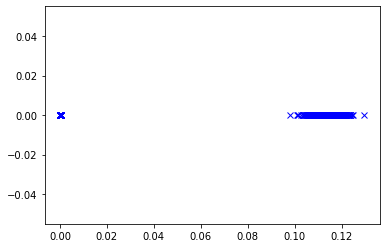

In [81]:
plt.plot(mse, np.zeros_like(mse), 'xb')

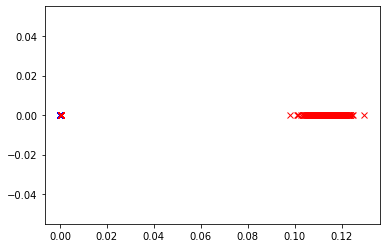

In [82]:
ar = mse[0:testSetBenignSize]
plt.plot(ar, np.zeros_like(ar), 'xb')
ar = mse[testSetBenignSize:]
plt.plot(ar, np.zeros_like(ar), 'xr')

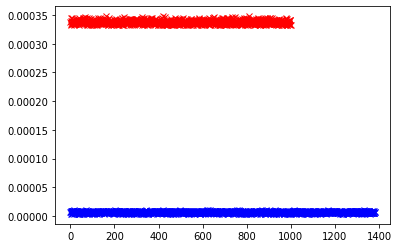

In [74]:
ar = mse[0:testSetBenignSize]
plt.plot(ar, 'xb')
ar = mse[testSetBenignSize+2000:testSetBenignSize+3000]
plt.plot(ar, 'xr')

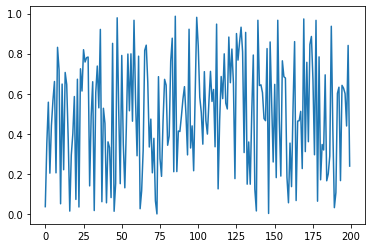

In [57]:
plt.plot(normalizedFDIAttackDataSet[1,:,1])

In [84]:
testSet.shape

(2382, 200, 9)